In [1]:
import numpy as np
from lbmpy.session import *
from lbmpy.fieldaccess import *
from pystencils import fields
from pystencils.session import *
from lbmpy.stencils import get_stencil
from pystencils.stencils import *
from lbmpy.macroscopic_value_kernels import pdf_initialization_assignments
from pystencils.boundaries import add_neumann_boundary, Neumann, Dirichlet, BoundaryHandling

from matplotlib import pyplot
import time
#this makes matplotlib plots appear in the notebook (instead of a separate window)
%matplotlib inline   

# Simulating a fully periodic shear flow problem

In this tutorial we will simulate a 2D fully periodic shear flow problem, which we will show with different propagation schemes. First of all, we will consider Two-step two-grid algorithms. The most prominent uses a pull streaming step another very commonly used is the push streaming step.

Afterwards we will show how to implement more advanced methods like the AA-pattern or the Esoteric twist.

In [2]:
omega_0 = 1.9
domain_size = (300, 300)
iterations = 4000
a = np.random.rand(*(domain_size[0], domain_size[1]))


dh = ps.create_data_handling((domain_size), periodicity = (True, True), default_target="cpu")
f1 = dh.add_array("f1", values_per_cell=9)
dh.fill("f1", 0.0, ghost_layers=True)
f2 = dh.add_array("f2", values_per_cell=9)
dh.fill("f2", 0.0, ghost_layers=True)
u = dh.add_array("u", values_per_cell=2)
dh.fill("u", 0.0, ghost_layers=True)

In [3]:
stencil = get_stencil("D2Q9")
stencil

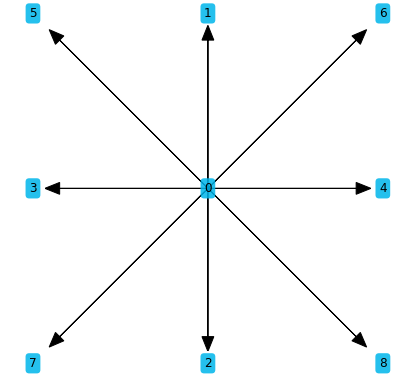

In [4]:
visualize_stencil(stencil)

In [5]:
cr = create_lb_collision_rule(stencil=stencil, compressible=False, output={"velocity": u}, relaxation_rate=omega_0)
method = cr.method

In [6]:
sym_pre = method.pre_collision_pdf_symbols
sym_post = method.post_collision_pdf_symbols

# The Stream Pull scheme

The Stream Pull is shown in the figure below

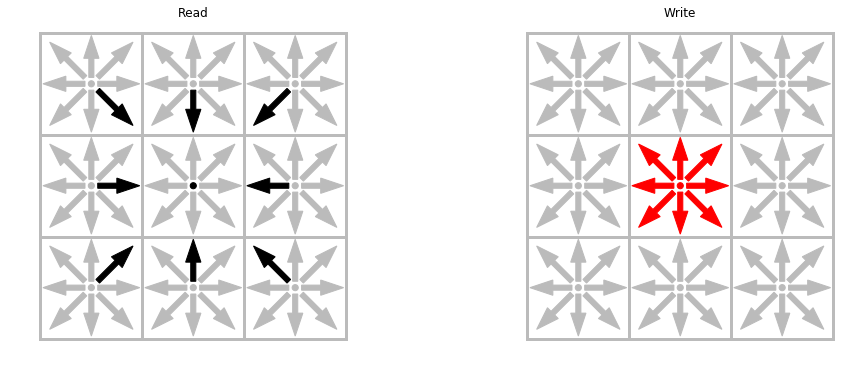

In [7]:
visualize_pdf_field_accessor(StreamPullTwoFieldsAccessor)

In [8]:
stream_pull_dict = {}
for i, direction in enumerate(stencil):
    inv_direction = tuple(-e for e in direction)
    stream_pull_dict[ sym_pre[i] ] = f1[inv_direction](i)
    stream_pull_dict[ sym_post[i] ] = f2(i)
    
stream_pull_dict

In [9]:
ur_pull = cr.new_with_substitutions(stream_pull_dict)

In [10]:
ur_pull

$$rr_{0} \leftarrow 1.9$$
"$$vel0Term \leftarrow {{f1}_{(-1,-1)}^{6}} + {{f1}_{(-1,0)}^{4}} + {{f1}_{(-1,1)}^{8}}$$"
"$$vel1Term \leftarrow {{f1}_{(0,-1)}^{1}} + {{f1}_{(1,-1)}^{5}}$$"
"$$\rho \leftarrow {{f1}_{(0,0)}} + {{f1}_{(0,1)}^{2}} + {{f1}_{(1,0)}^{3}} + {{f1}_{(1,1)}^{7}} + vel0Term + vel1Term$$"
"$$u_{0} \leftarrow - {{f1}_{(1,-1)}^{5}} - {{f1}_{(1,0)}^{3}} - {{f1}_{(1,1)}^{7}} + vel0Term$$"
"$$u_{1} \leftarrow {{f1}_{(-1,-1)}^{6}} - {{f1}_{(-1,1)}^{8}} - {{f1}_{(0,1)}^{2}} - {{f1}_{(1,1)}^{7}} + vel1Term$$"
$$u0Mu1 \leftarrow u_{0} - u_{1}$$
$$u0Pu1 \leftarrow u_{0} + u_{1}$$
$$f_{eq common} \leftarrow \rho - \frac{3 u_{0}^{2}}{2} - \frac{3 u_{1}^{2}}{2}$$
"$${{f2}_{(0,0)}} \leftarrow {{f1}_{(0,0)}} + rr_{0} \left(- {{f1}_{(0,0)}} + \frac{4 f_{eq common}}{9}\right)$$"
"$${{f2}_{(0,0)}^{1}} \leftarrow {{f1}_{(0,-1)}^{1}} + rr_{0} \left(- {{f1}_{(0,-1)}^{1}} + \frac{f_{eq common}}{9} + \frac{u_{1}^{2}}{2} + \frac{u_{1}}{3}\right)$$"


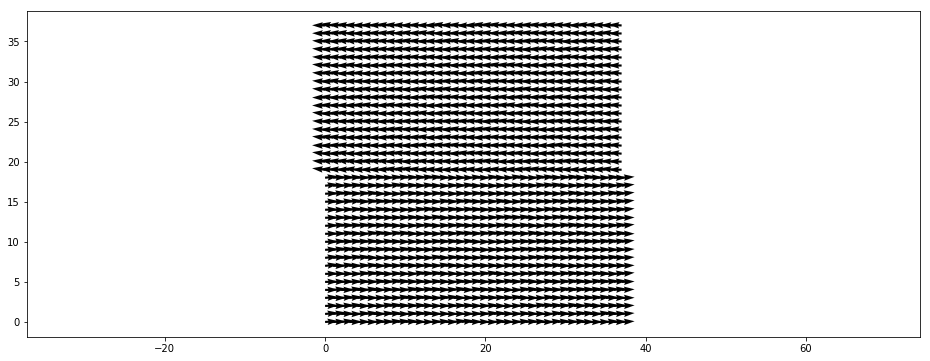

In [11]:
yHalf = (domain_size[1] + 2)//2
dh.cpu_arrays.u[1:-1, 1:yHalf, 0] = 0.08
dh.cpu_arrays.u[1:-1, yHalf:-1, 0] = -0.08
dh.cpu_arrays.u[1:-1, 1:-1, 1] += a * 1e-2
plt.vector_field(dh.cpu_arrays.u[1:-1,1:-1,:], step=8);

In [12]:
# initialize the pdfs
initial_assignments = pdf_initialization_assignments(method, 1.0, u.center_vector, f1.center_vector)
ast_initial = ps.create_kernel(initial_assignments, target=dh.default_target)

kernel_initial = ast_initial.compile() #compile the kernel to produce C-Code

In [13]:
# stream collide
ast_lb_step_pull = ps.create_kernel(ur_pull)

kernel_lb_step_pull = ast_lb_step_pull.compile() #compile the kernel to produce C-Code

In [14]:
# claculate conserved quantity
cqc = method.conserved_quantity_computation
cqc = cqc.output_equations_from_pdfs(f1.center_vector, {"velocity": u})
ast_cqc = ps.create_kernel(cqc, target=dh.default_target)

kernel_cqc = ast_cqc.compile() #compile the kernel to produce C-Code

In [15]:
# take care of periodic boundary
sync_kernel_pull_f1 = dh.synchronization_function(f1.name, 'D2Q9', target=dh.default_target, update_rule=ur_pull)

In [16]:
# run the simulation
dh.run_kernel(kernel_initial)

for i in range(iterations):
    sync_kernel_pull_f1()
    dh.run_kernel(kernel_lb_step_pull)
    dh.swap("f1", "f2")
    
    
dh.run_kernel(kernel_cqc)

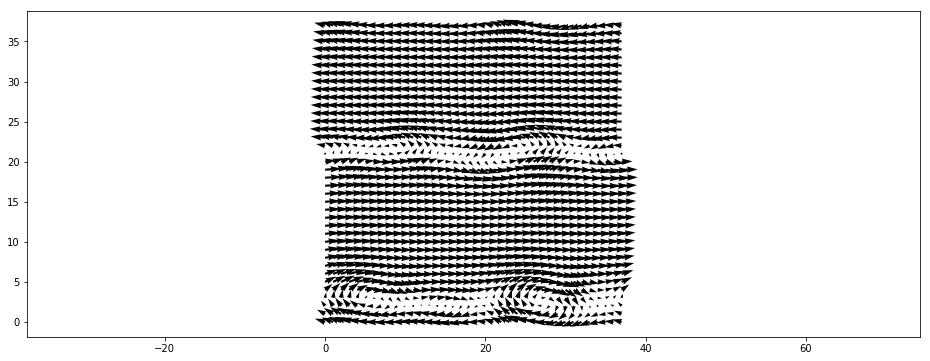

In [17]:
plt.vector_field(dh.cpu_arrays.u[1:-1,1:-1,:], step=8);

# The Stream Push Scheme

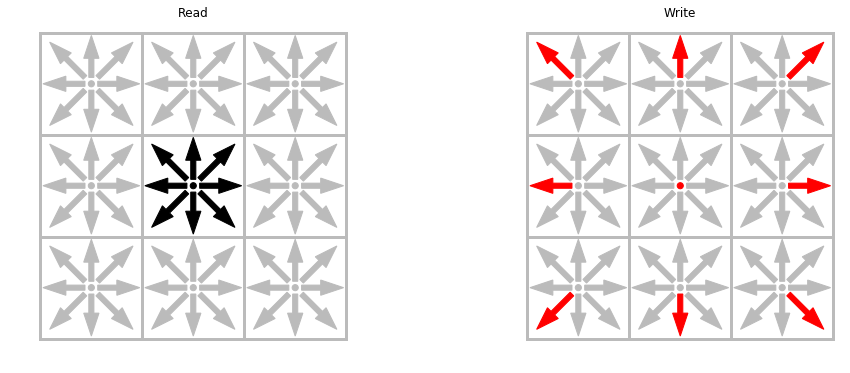

In [18]:
visualize_pdf_field_accessor(StreamPushTwoFieldsAccessor)

In [19]:
stream_push_dict = {}
for i, direction in enumerate(stencil):
    stream_push_dict[ sym_pre[i] ] = f1(i)
    stream_push_dict[ sym_post[i] ] = f2[direction](i)
    
stream_push_dict

In [20]:
ur_push = cr.new_with_substitutions(stream_push_dict)
ur_push

$$rr_{0} \leftarrow 1.9$$
"$$vel0Term \leftarrow {{f1}_{(0,0)}^{4}} + {{f1}_{(0,0)}^{6}} + {{f1}_{(0,0)}^{8}}$$"
"$$vel1Term \leftarrow {{f1}_{(0,0)}^{1}} + {{f1}_{(0,0)}^{5}}$$"
"$$\rho \leftarrow {{f1}_{(0,0)}} + {{f1}_{(0,0)}^{2}} + {{f1}_{(0,0)}^{3}} + {{f1}_{(0,0)}^{7}} + vel0Term + vel1Term$$"
"$$u_{0} \leftarrow - {{f1}_{(0,0)}^{3}} - {{f1}_{(0,0)}^{5}} - {{f1}_{(0,0)}^{7}} + vel0Term$$"
"$$u_{1} \leftarrow - {{f1}_{(0,0)}^{2}} + {{f1}_{(0,0)}^{6}} - {{f1}_{(0,0)}^{7}} - {{f1}_{(0,0)}^{8}} + vel1Term$$"
$$u0Mu1 \leftarrow u_{0} - u_{1}$$
$$u0Pu1 \leftarrow u_{0} + u_{1}$$
$$f_{eq common} \leftarrow \rho - \frac{3 u_{0}^{2}}{2} - \frac{3 u_{1}^{2}}{2}$$
"$${{f2}_{(0,0)}} \leftarrow {{f1}_{(0,0)}} + rr_{0} \left(- {{f1}_{(0,0)}} + \frac{4 f_{eq common}}{9}\right)$$"
"$${{f2}_{(0,1)}^{1}} \leftarrow {{f1}_{(0,0)}^{1}} + rr_{0} \left(- {{f1}_{(0,0)}^{1}} + \frac{f_{eq common}}{9} + \frac{u_{1}^{2}}{2} + \frac{u_{1}}{3}\right)$$"


In [21]:
dh.fill("f1", 0.0, ghost_layers=True)
dh.fill("f2", 0.0, ghost_layers=True)
dh.fill("u", 0.0, ghost_layers=True)

In [22]:
yHalf = (domain_size[1] + 2)//2
dh.cpu_arrays.u[1:-1, 1:yHalf, 0] = 0.08
dh.cpu_arrays.u[1:-1, yHalf:-1, 0] = -0.08
dh.cpu_arrays.u[1:-1, 1:-1, 1] += a * 1e-2

In [23]:
ast_lb_step_push = ps.create_kernel(ur_push)

kernel_lb_step_push = ast_lb_step_push.compile()

In [24]:
sync_kernel_push_f2 = dh.get_communication_after_sweep(f2.name, 'D2Q9', update_rule=ur_push)

In [25]:
dh.run_kernel(kernel_initial)

for i in range(iterations):
    dh.run_kernel(kernel_lb_step_push)
    sync_kernel_push_f2()
    dh.swap("f1", "f2")
    
    
dh.run_kernel(kernel_cqc)

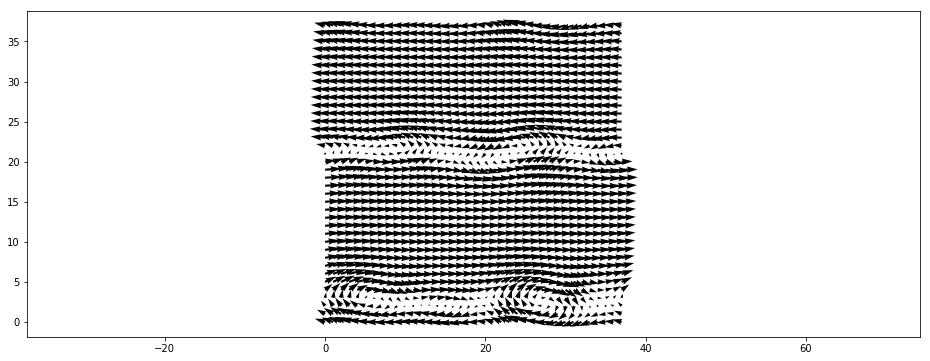

In [26]:
plt.vector_field(dh.cpu_arrays.u[1:-1,1:-1,:], step=8);

# The Esotheric Twist

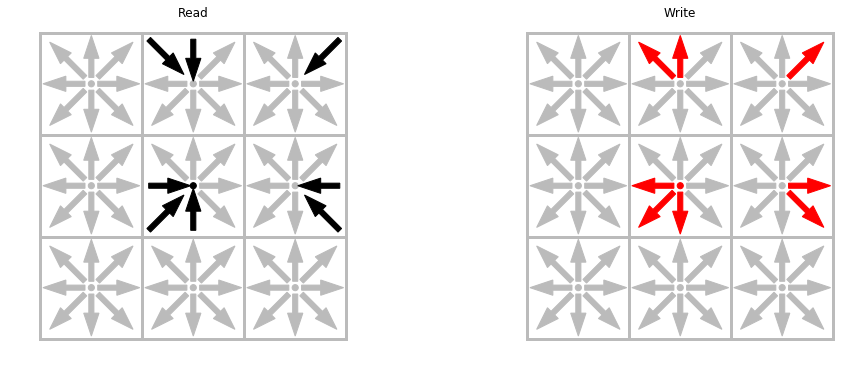

In [27]:
eso_odd = EsoTwistOddTimeStepAccessor()
visualize_pdf_field_accessor(eso_odd)

In [28]:
#eso_odd.read()

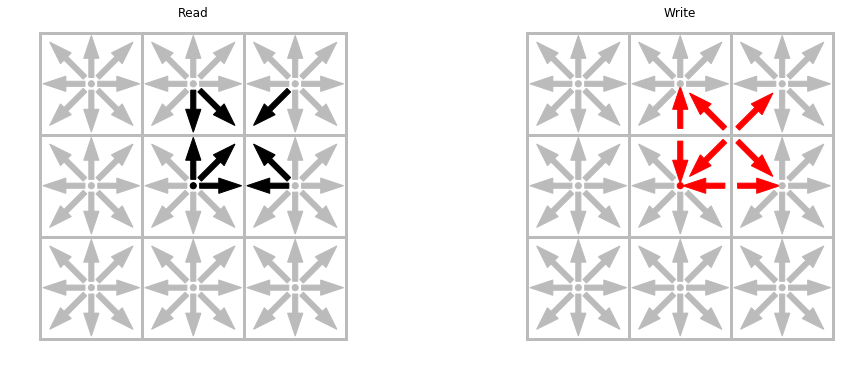

In [29]:
eso_even = EsoTwistEvenTimeStepAccessor()
visualize_pdf_field_accessor(eso_even)

In [30]:
dh.fill("f1", 0.0, ghost_layers=True)
dh.fill("u", 0.0, ghost_layers=True)

In [31]:
yHalf = (domain_size[1] + 2)//2
dh.cpu_arrays.u[1:-1, 1:yHalf, 0] = 0.08
dh.cpu_arrays.u[1:-1, yHalf:-1, 0] = -0.08
dh.cpu_arrays.u[1:-1, 1:-1, 1] += a * 1e-2

In [32]:
eso_odd = EsoTwistOddTimeStepAccessor()
pre_collision_accesses_odd = eso_odd.read(f1, stencil)
post_collision_accesses_odd = eso_odd.write(f1, stencil)


eso_odd = EsoTwistEvenTimeStepAccessor()
pre_collision_accesses_even = eso_odd.read(f1, stencil)
post_collision_accesses_even = eso_odd.write(f1, stencil)

In [33]:
Eso_odd_dict = {}
for i, direction in enumerate(stencil):
    Eso_odd_dict[sym_pre[i]] = pre_collision_accesses_odd[i]
    Eso_odd_dict[sym_post[i]] = post_collision_accesses_odd[i]
    
Eso_odd_dict

In [34]:
ur_eso_odd = cr.new_with_substitutions(Eso_odd_dict)
ur_eso_odd = ps.simp.add_subexpressions_for_field_reads(ur_eso_odd)

ast_lb_eso_odd = ps.create_kernel(ur_eso_odd)

kernel_lb_eso_odd = ast_lb_eso_odd.compile()

In [35]:
#ur_eso_odd

In [36]:
Eso_even_dict = {}
for i, direction in enumerate(stencil):
    Eso_even_dict[sym_pre[i]] = pre_collision_accesses_even[i]
    Eso_even_dict[sym_post[i]] = post_collision_accesses_even[i]
    
Eso_even_dict

In [37]:
ur_eso_even = cr.new_with_substitutions(Eso_even_dict)
ur_eso_even = ps.simp.add_subexpressions_for_field_reads(ur_eso_even)

ast_lb_eso_even = ps.create_kernel(ur_eso_even)

kernel_lb_eso_even = ast_lb_eso_even.compile()

In [38]:
#ur_eso_even

In [39]:
sync_odd_pull = dh.get_communication_before_sweep(f1.name, 'D2Q9', update_rule=ur_eso_odd)
sync_odd_push = dh.get_communication_after_sweep(f1.name, 'D2Q9', update_rule=ur_eso_odd)

sync_even_pull = dh.get_communication_before_sweep(f1.name, 'D2Q9', update_rule=ur_eso_even)
sync_even_push = dh.get_communication_after_sweep(f1.name, 'D2Q9', update_rule=ur_eso_even)

In [40]:
dh.run_kernel(kernel_initial)

for i in range(iterations):
    # even steps
    if i % 2 == 0:
        sync_even_pull()
        dh.run_kernel(kernel_lb_eso_even)
        sync_even_push()
        
    # odd steps
    else:
        sync_odd_pull()
        dh.run_kernel(kernel_lb_eso_odd)
        sync_odd_push()
    
    
dh.run_kernel(kernel_cqc)

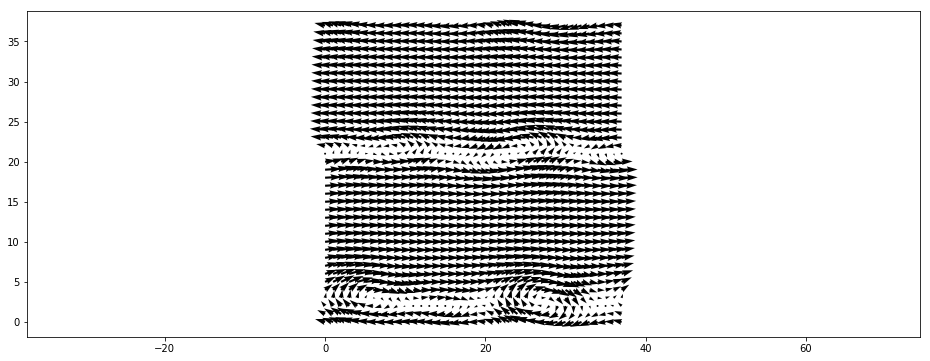

In [41]:
plt.vector_field(dh.cpu_arrays.u[1:-1,1:-1,:], step=8);

# AA Pattern

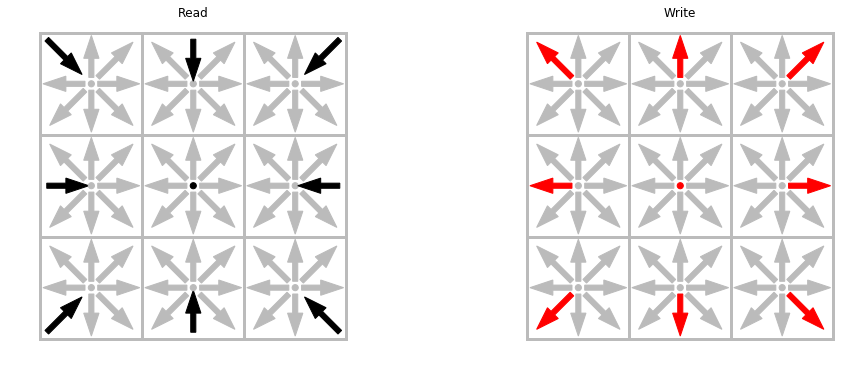

In [42]:
aa_odd = AAOddTimeStepAccessor()
visualize_pdf_field_accessor(aa_odd)

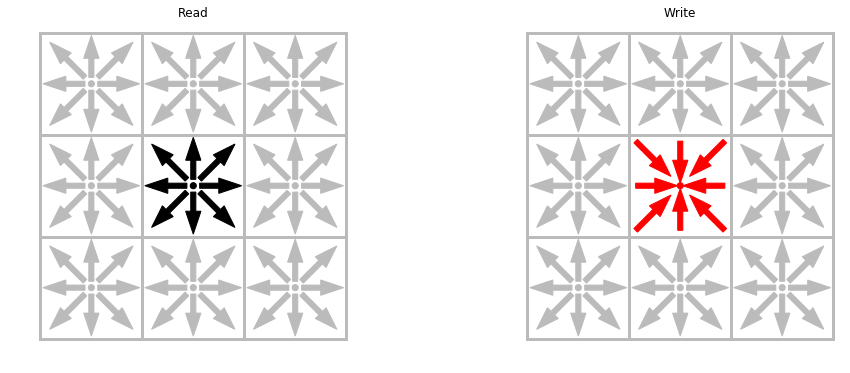

In [43]:
aa_even = AAEvenTimeStepAccessor()
visualize_pdf_field_accessor(aa_even)

In [44]:
dh.fill("f1", 0.0, ghost_layers=True)
dh.fill("u", 0.0, ghost_layers=True)

In [45]:
yHalf = (domain_size[1] + 2)//2
dh.cpu_arrays.u[1:-1, 1:yHalf, 0] = 0.08
dh.cpu_arrays.u[1:-1, yHalf:-1, 0] = -0.08
dh.cpu_arrays.u[1:-1, 1:-1, 1] += a * 1e-2

In [46]:
aa_odd = AAOddTimeStepAccessor()
pre_collision_accesses_odd = aa_odd.read(f1, stencil)
post_collision_accesses_odd = aa_odd.write(f1, stencil)


aa_even = AAEvenTimeStepAccessor()
pre_collision_accesses_even = aa_even.read(f1, stencil)
post_collision_accesses_even = aa_even.write(f1, stencil)

In [47]:
AA_odd_dict = {}
for i, direction in enumerate(stencil):
    AA_odd_dict[sym_pre[i]] = pre_collision_accesses_odd[i]
    AA_odd_dict[sym_post[i]] = post_collision_accesses_odd[i]
    
AA_odd_dict

In [48]:
ur_aa_odd = cr.new_with_substitutions(AA_odd_dict)
ur_aa_odd = ps.simp.add_subexpressions_for_field_reads(ur_aa_odd)

ast_lb_aa_odd = ps.create_kernel(ur_aa_odd)

kernel_lb_aa_odd = ast_lb_aa_odd.compile()

In [49]:
AA_even_dict = {}
for i, direction in enumerate(stencil):
    AA_even_dict[sym_pre[i]] = pre_collision_accesses_even[i]
    AA_even_dict[sym_post[i]] = post_collision_accesses_even[i]
    
AA_even_dict

In [50]:
ur_aa_even = cr.new_with_substitutions(AA_even_dict)
ur_aa_even = ps.simp.add_subexpressions_for_field_reads(ur_aa_even)

ast_lb_aa_even = ps.create_kernel(ur_aa_even)

kernel_lb_aa_even = ast_lb_aa_even.compile()

In [51]:
sync_odd_pull = dh.get_communication_before_sweep(f1.name, 'D2Q9', update_rule=ur_aa_odd)
sync_odd_push = dh.get_communication_after_sweep(f1.name, 'D2Q9', update_rule=ur_aa_odd)

sync_even_pull = dh.get_communication_before_sweep(f1.name, 'D2Q9', update_rule=ur_aa_even)
sync_even_push = dh.get_communication_after_sweep(f1.name, 'D2Q9', update_rule=ur_aa_even)

In [52]:
dh.run_kernel(kernel_initial)

for i in range(iterations):
    # even steps
    if i % 2 == 0:
        sync_even_pull()
        dh.run_kernel(kernel_lb_aa_even)
        sync_even_push()
        
    # odd steps
    else:
        sync_odd_pull()
        dh.run_kernel(kernel_lb_aa_odd)
        sync_odd_push()
    
    
dh.run_kernel(kernel_cqc)

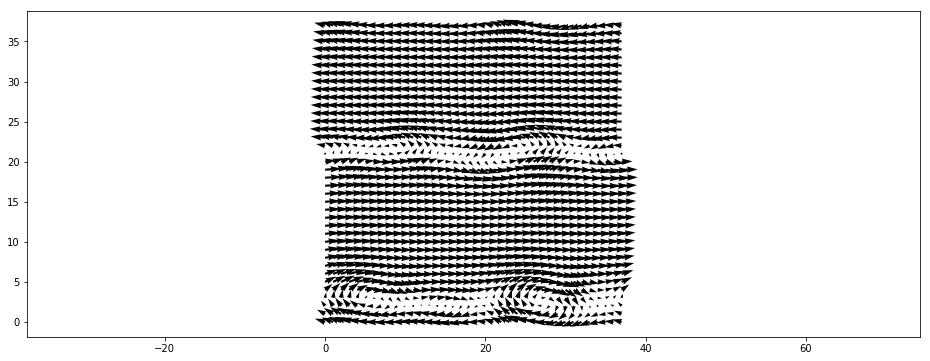

In [53]:
plt.vector_field(dh.cpu_arrays.u[1:-1,1:-1,:], step=8);

# Use predefined method to tackle the simulation

In [54]:
yHalf = domain_size[1]//2
initial_velocity = np.zeros(domain_size + (2,))
initial_velocity[:, :yHalf, 0] =  0.08
initial_velocity[:, yHalf:, 0] = -0.08
initial_velocity[:, :, 1] += a * 1e-2
sc = create_fully_periodic_flow(initial_velocity, relaxation_rate=omega_0)
sc.run(iterations)

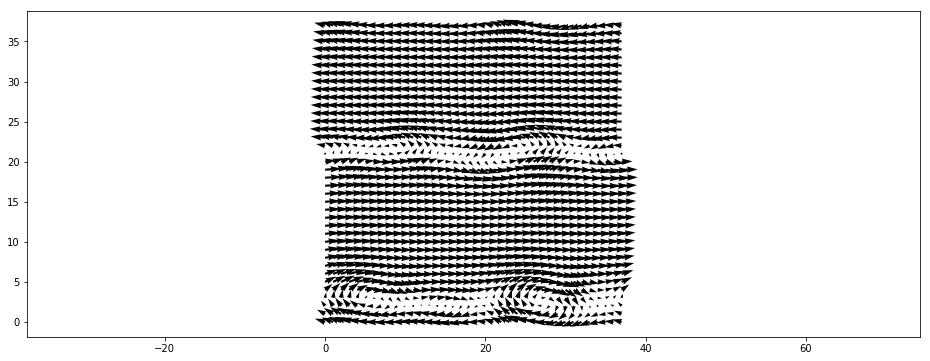

In [55]:
plt.vector_field(sc.velocity[:, :, :], step=8)

In [56]:
np.testing.assert_almost_equal(sc.velocity[:, :, :], dh.cpu_arrays.u[1:-1,1:-1,:], decimal=10)